<a href="https://colab.research.google.com/github/OlegV12/ML_in_business/blob/Lesson_5/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [663]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

%matplotlib inline

In [664]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [665]:
df = pd.read_csv('/gdrive/MyDrive/churn_data.csv')

In [666]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [667]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


class Standartizer(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        self.scaler.fit(X)
        return self

    def transform(self, X):
        for col_ in self.columns:

            X[self.columns] = scaler.transform(X[col_], copy=False)
        return X

In [668]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [669]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


In [670]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('std', Standartizer(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [671]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [672]:
feats

FeatureUnion(n_jobs=None,
             transformer_list=[('Geography',
                                Pipeline(memory=None,
                                         steps=[('selector',
                                                 FeatureSelector(column='Geography')),
                                                ('ohe',
                                                 OHEEncoder(key='Geography'))],
                                         verbose=False)),
                               ('Gender',
                                Pipeline(memory=None,
                                         steps=[('selector',
                                                 FeatureSelector(column='Gender')),
                                                ('ohe',
                                                 OHEEncoder(key='Gender'))],
                                         verbose=False)),
                               ('Tenure',
                                Pipeline(memory=None...
   

In [673]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [674]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [675]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]

In [676]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [677]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


In [678]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


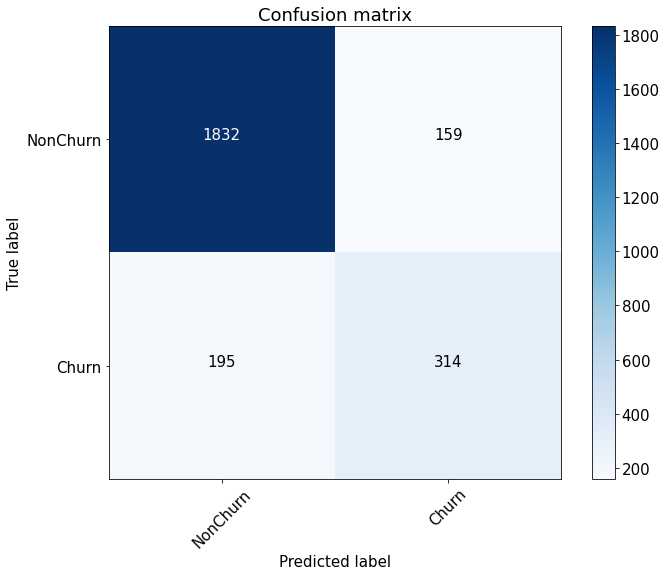

In [679]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

rf_cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(rf_cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [680]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [681]:
gbc_pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42, n_estimators=1000, learning_rate=0.001, min_samples_leaf=10, max_depth=4,)),
])

In [682]:
gbc_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [683]:
gbc_preds = gbc_pipeline.predict_proba(X_test)[:, 1]
gbc_precision, gbc_recall, gbc_thresholds = precision_recall_curve(y_test, gbc_preds)

gbc_fscore = (2 * gbc_precision * gbc_recall) / (gbc_precision + gbc_recall)
# locate the index of the largest f score
gbc_ix = np.argmax(gbc_fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (gbc_thresholds[gbc_ix], 
                                                                        gbc_fscore[gbc_ix],
                                                                        gbc_precision[gbc_ix],
                                                                        gbc_recall[gbc_ix]))

Best Threshold=0.280223, F-Score=0.629, Precision=0.617, Recall=0.640


In [684]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0,)

In [685]:
lr_pipeline = Pipeline([
    ('features',feats),
    ('lr', LogisticRegression(random_state = 42,)),
])

In [686]:
lr_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [687]:
lr_preds = lr_pipeline.predict_proba(X_test)[:, 1]
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(y_test, lr_preds)

lr_fscore = (2 * lr_precision * lr_recall) / (lr_precision + lr_recall + np.nextafter(0, 1))
# locate the index of the largest f score
lr_ix = np.argmax(lr_fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (lr_thresholds[lr_ix], 
                                                                        lr_fscore[lr_ix],
                                                                        lr_precision[lr_ix],
                                                                        lr_recall[lr_ix]))
lr_cnf_matrix = confusion_matrix(y_test, lr_preds>lr_thresholds[lr_ix])

Best Threshold=0.199920, F-Score=0.411, Precision=0.296, Recall=0.676


Полагаю, что лучшая модель в данном случае это бустинг так как у нее максимальный recall, думаю что именно эта метрика является важной в нашем примере, но и минимальный precision мы иметь не можем, т.к. тогда у нас будут большеи издержки на удержание пользователей которые и так от нас не уходят.

Confusion matrix, without normalization
[[1790  201]
 [ 184  325]]


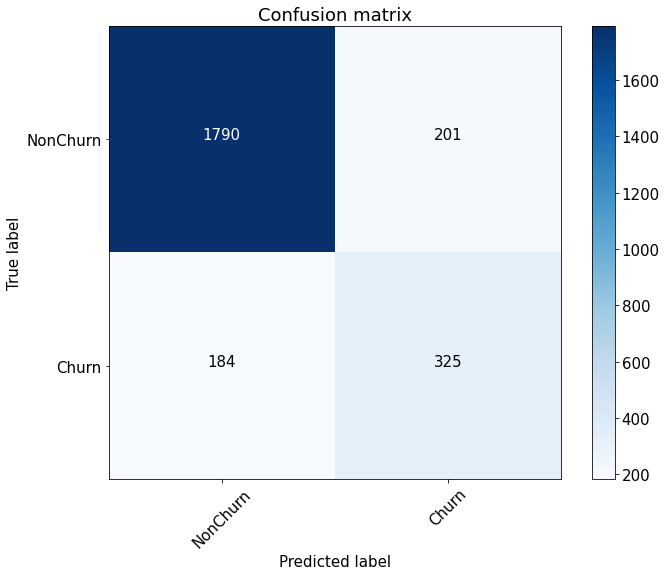

In [688]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, gbc_preds>gbc_thresholds[gbc_ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.show()

In [689]:
# посчитаем затраты на компанию 
cnf_matrix[0][1] + cnf_matrix[1][1]

526

In [690]:
# вернется нам 
cnf_matrix[1][1] * 2

650

In [691]:
# итог
(cnf_matrix[1][1] * 2) - (cnf_matrix[0][1] + cnf_matrix[1][1])

124

Сравним с экономическую эффективность других моделей

In [692]:
# итог по случайному лесу
(rf_cnf_matrix[1][1] * 2) - (rf_cnf_matrix[0][1] + rf_cnf_matrix[1][1])

155

In [693]:
# итог по логистической регрессии
(lr_cnf_matrix[1][1] * 2) - (lr_cnf_matrix[0][1] + lr_cnf_matrix[1][1])

-476

В плане экономики (именно для заданных параметров 1usd на превлечение и 2usd c удержанного пользователя), лучше оказалась модель случайного леса. (но мы не знаем стоимость ушедшего пользователя) 